In [1]:
# %load C:\Users\sachu\Desktop\My_Documents\Thesis\Base_model\Existing_model\gesture_classification\run_classification.py
from argparse import ArgumentParser
import logging

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from gesture_classification.datasets import SnippetClassificationLightningDataset
from gesture_classification.model import LitModel
from gesture_classification.helpers import (
    get_num_frames, get_subsample_rate,
    get_accelerator, parse_use_keypoints
)
from gesture_classification.constants import SEED

logging.getLogger("lightning").setLevel(logging.WARNING)




/home/h6/sapo684c/Thesis/Gesture_Classification/arupi_alp/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/h6/sapo684c/Thesis/Gesture_Classification/arupi_alp/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import re
import time
dataset_home = r'/beegfs/.global0/ws/sapo684c-sac_space/Ellen_Dataset_with_Optical_Flow_Masking_Final/ellen_show_length_1300_sample_rate_1_iou_0.55'
logger_name = "gesture_classification"
logger_folder = r'/beegfs/ws/0/sapo684c-sac_space/Gesture_Classification/Logger_File'
batch_size = 1
model_name = "videomae"
pretrained_model = "MCG-NJU/videomae-base-finetuned-ssv2"
#zero_normalisation=True
nodes = 1
gpus = 1
epochs = 2
num_workers = 16 * gpus
accumulate_batches = 8
learning_rate = 1e-5
save_top_k = 1
precision = 16
use_keypoints = 0
seed_everything(SEED, workers=True)
subsample_rate = get_subsample_rate(dataset_home)
num_frames = get_num_frames(dataset_home, subsample_rate)
accelerator = get_accelerator()
dm = SnippetClassificationLightningDataset(
    dataset_home, 
    batch_size, 
    num_workers, 
    subsample_rate, 
    num_frames,
    #zero_normalisation,
    use_keypoints, 
    )
model = LitModel(
    model_name, pretrained_model, num_frames, learning_rate, use_keypoints
    )
model.save_hyperparameters()
checkpoint_f1 = ModelCheckpoint(
    save_top_k=save_top_k, mode="max", monitor="val_f1",
    filename="checkpoint-{epoch:02d}-{val_f1:.2f}"
    )
checkpoint_acc = ModelCheckpoint(
    save_top_k=save_top_k, mode="max", monitor="val_acc",
    filename="checkpoint-{epoch:02d}-{val_acc:.2f}"
    )
lr_monitor = LearningRateMonitor(logging_interval="step")

checkpoint_path = r'/beegfs/ws/0/sapo684c-sac_space/Gesture_Classification/Logger_File/gesture_classification/version_162/checkpoints/checkpoint-epoch=135-val_acc=0.79.ckpt'
loaded_model = model.load_from_checkpoint(checkpoint_path,num_frames =num_frames)
match = re.search(r'version_(\d+)', checkpoint_path)
version_string=match.group(0)

#logger = TensorBoardLogger(
 #   name=logger_name,
  #  save_dir=logger_folder)
trainer = Trainer(
    accelerator=accelerator,
    devices=gpus,
    num_nodes=nodes,
    max_epochs=epochs,
    strategy='dp',
    precision=precision,
    enable_progress_bar=False,
    callbacks=[checkpoint_f1, checkpoint_acc, lr_monitor],
    #logger=logger,
    accumulate_grad_batches=accumulate_batches,
    )
#test_results = trainer.test(loaded_model, dm)
start_time= time.time()
test_results = trainer.test(loaded_model, dm.train_dataloader())
end_time = time.time()
total_time =end_time-start_time
print(f"Total Time: {total_time:.2f} seconds")
"""
parser = ArgumentParser()
parser.add_argument("--dataset-home", type=str, default =r'/beegfs/ws/0/sapo684c-sac_space/ellen_show_dataset_trial_OF/ellen_show_length_1300_sample_rate_8_iou_0.55')
parser.add_argument("--logger-name", type=str, default="gesture_classification")
parser.add_argument("--logger-folder", type=str, default=r'/beegfs/ws/0/sapo684c-sac_space/Gesture_Classification/Logger_File')
parser.add_argument("--pretrained-model", type=str, default="")
parser.add_argument("--pretrained-dataset", type=str, default="ssv2")
parser.add_argument("--batch-size", type=int, default=2)
parser.add_argument("--precision", type=int, default=16)
parser.add_argument("--save-top-k", type=int, default=1)
parser.add_argument("--learning-rate", type=float, default=1e-4)
parser.add_argument("--nodes", type=int, default=1)
parser.add_argument("--gpus", type=int, default=1)
parser.add_argument("--workers-per-gpu", type=int, default=16)
parser.add_argument("--accumulate-batches", type=int, default=8)
parser.add_argument("--epochs", type=int,default=2)
parser.add_argument("--use-keypoints", default=0)
parser.add_argument("--model-name", type=str,default="videomae")
args = parser.parse_args()

if __name__ == "__main__":
    main(args)
"""
    

[rank: 0] Global seed set to 34
Some weights of the model checkpoint at MCG-NJU/videomae-base-finetuned-ssv2 were not used when initializing VideoMAEForVideoClassification: ['videomae.encoder.layer.7.attention.attention.v_bias', 'videomae.encoder.layer.5.attention.attention.q_bias', 'videomae.encoder.layer.10.attention.attention.q_bias', 'videomae.encoder.layer.5.attention.attention.v_bias', 'videomae.encoder.layer.2.attention.attention.q_bias', 'videomae.encoder.layer.3.attention.attention.v_bias', 'videomae.encoder.layer.11.attention.attention.q_bias', 'videomae.encoder.layer.6.attention.attention.v_bias', 'videomae.encoder.layer.0.attention.attention.q_bias', 'videomae.encoder.layer.9.attention.attention.v_bias', 'videomae.encoder.layer.3.attention.attention.q_bias', 'videomae.encoder.layer.2.attention.attention.v_bias', 'videomae.encoder.layer.8.attention.attention.v_bias', 'videomae.encoder.layer.8.attention.attention.q_bias', 'videomae.encoder.layer.10.attention.attention.v_bias'

probab tensor([0.0341], device='cuda:0', dtype=torch.float16)
probab tensor([0.0760], device='cuda:0', dtype=torch.float16)
probab tensor([0.0284], device='cuda:0', dtype=torch.float16)
probab tensor([0.0424], device='cuda:0', dtype=torch.float16)
probab tensor([0.0185], device='cuda:0', dtype=torch.float16)
probab tensor([0.0465], device='cuda:0', dtype=torch.float16)
probab tensor([0.0266], device='cuda:0', dtype=torch.float16)
probab tensor([0.0500], device='cuda:0', dtype=torch.float16)
probab tensor([0.7822], device='cuda:0', dtype=torch.float16)
probab tensor([0.1649], device='cuda:0', dtype=torch.float16)
probab tensor([0.1512], device='cuda:0', dtype=torch.float16)
probab tensor([0.0337], device='cuda:0', dtype=torch.float16)
probab tensor([0.0649], device='cuda:0', dtype=torch.float16)
probab tensor([0.1511], device='cuda:0', dtype=torch.float16)
probab tensor([0.0403], device='cuda:0', dtype=torch.float16)
probab tensor([0.0319], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.0328], device='cuda:0', dtype=torch.float16)
probab tensor([0.1665], device='cuda:0', dtype=torch.float16)
probab tensor([0.9932], device='cuda:0', dtype=torch.float16)
probab tensor([0.9814], device='cuda:0', dtype=torch.float16)
probab tensor([0.0478], device='cuda:0', dtype=torch.float16)
probab tensor([0.9922], device='cuda:0', dtype=torch.float16)
probab tensor([0.9932], device='cuda:0', dtype=torch.float16)
probab tensor([0.9966], device='cuda:0', dtype=torch.float16)
probab tensor([0.0613], device='cuda:0', dtype=torch.float16)
probab tensor([0.9854], device='cuda:0', dtype=torch.float16)
probab tensor([0.2837], device='cuda:0', dtype=torch.float16)
probab tensor([0.2229], device='cuda:0', dtype=torch.float16)
probab tensor([0.9702], device='cuda:0', dtype=torch.float16)
probab tensor([0.7012], device='cuda:0', dtype=torch.float16)
probab tensor([0.9292], device='cuda:0', dtype=torch.float16)
probab tensor([0.9951], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.0346], device='cuda:0', dtype=torch.float16)
probab tensor([0.1086], device='cuda:0', dtype=torch.float16)
probab tensor([0.0557], device='cuda:0', dtype=torch.float16)
probab tensor([0.0640], device='cuda:0', dtype=torch.float16)
probab tensor([0.0677], device='cuda:0', dtype=torch.float16)
probab tensor([0.0748], device='cuda:0', dtype=torch.float16)
probab tensor([0.0690], device='cuda:0', dtype=torch.float16)
probab tensor([0.8066], device='cuda:0', dtype=torch.float16)
probab tensor([0.1394], device='cuda:0', dtype=torch.float16)
probab tensor([0.3550], device='cuda:0', dtype=torch.float16)
probab tensor([0.0433], device='cuda:0', dtype=torch.float16)
probab tensor([0.0550], device='cuda:0', dtype=torch.float16)
probab tensor([0.0335], device='cuda:0', dtype=torch.float16)
probab tensor([0.0350], device='cuda:0', dtype=torch.float16)
probab tensor([0.0440], device='cuda:0', dtype=torch.float16)
probab tensor([0.0277], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9663], device='cuda:0', dtype=torch.float16)
probab tensor([0.6021], device='cuda:0', dtype=torch.float16)
probab tensor([0.9526], device='cuda:0', dtype=torch.float16)
probab tensor([0.1924], device='cuda:0', dtype=torch.float16)
probab tensor([0.7188], device='cuda:0', dtype=torch.float16)
probab tensor([0.9854], device='cuda:0', dtype=torch.float16)
probab tensor([0.3035], device='cuda:0', dtype=torch.float16)
probab tensor([0.0795], device='cuda:0', dtype=torch.float16)
probab tensor([0.0463], device='cuda:0', dtype=torch.float16)
probab tensor([0.2820], device='cuda:0', dtype=torch.float16)
probab tensor([0.9771], device='cuda:0', dtype=torch.float16)
probab tensor([0.9824], device='cuda:0', dtype=torch.float16)
probab tensor([0.9922], device='cuda:0', dtype=torch.float16)
probab tensor([0.9849], device='cuda:0', dtype=torch.float16)
probab tensor([0.9785], device='cuda:0', dtype=torch.float16)
probab tensor([0.3438], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.5166], device='cuda:0', dtype=torch.float16)
probab tensor([0.1007], device='cuda:0', dtype=torch.float16)
probab tensor([0.3059], device='cuda:0', dtype=torch.float16)
probab tensor([0.2040], device='cuda:0', dtype=torch.float16)
probab tensor([0.1236], device='cuda:0', dtype=torch.float16)
probab tensor([0.1592], device='cuda:0', dtype=torch.float16)
probab tensor([0.5840], device='cuda:0', dtype=torch.float16)
probab tensor([0.4944], device='cuda:0', dtype=torch.float16)
probab tensor([0.8569], device='cuda:0', dtype=torch.float16)
probab tensor([0.0523], device='cuda:0', dtype=torch.float16)
probab tensor([0.0717], device='cuda:0', dtype=torch.float16)
probab tensor([0.0820], device='cuda:0', dtype=torch.float16)
probab tensor([0.4209], device='cuda:0', dtype=torch.float16)
probab tensor([0.3267], device='cuda:0', dtype=torch.float16)
probab tensor([0.0298], device='cuda:0', dtype=torch.float16)
probab tensor([0.4238], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.2781], device='cuda:0', dtype=torch.float16)
probab tensor([0.6831], device='cuda:0', dtype=torch.float16)
probab tensor([0.2725], device='cuda:0', dtype=torch.float16)
probab tensor([0.2418], device='cuda:0', dtype=torch.float16)
probab tensor([0.6191], device='cuda:0', dtype=torch.float16)
probab tensor([0.7939], device='cuda:0', dtype=torch.float16)
probab tensor([0.6040], device='cuda:0', dtype=torch.float16)
probab tensor([0.7803], device='cuda:0', dtype=torch.float16)
probab tensor([0.1089], device='cuda:0', dtype=torch.float16)
probab tensor([0.8828], device='cuda:0', dtype=torch.float16)
probab tensor([0.0393], device='cuda:0', dtype=torch.float16)
probab tensor([0.8027], device='cuda:0', dtype=torch.float16)
probab tensor([0.1049], device='cuda:0', dtype=torch.float16)
probab tensor([0.2576], device='cuda:0', dtype=torch.float16)
probab tensor([0.0850], device='cuda:0', dtype=torch.float16)
probab tensor([0.0984], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.7632], device='cuda:0', dtype=torch.float16)
probab tensor([0.0919], device='cuda:0', dtype=torch.float16)
probab tensor([0.9126], device='cuda:0', dtype=torch.float16)
probab tensor([0.0500], device='cuda:0', dtype=torch.float16)
probab tensor([0.5464], device='cuda:0', dtype=torch.float16)
probab tensor([0.9785], device='cuda:0', dtype=torch.float16)
probab tensor([0.0876], device='cuda:0', dtype=torch.float16)
probab tensor([0.0840], device='cuda:0', dtype=torch.float16)
probab tensor([0.1952], device='cuda:0', dtype=torch.float16)
probab tensor([0.9624], device='cuda:0', dtype=torch.float16)
probab tensor([0.5762], device='cuda:0', dtype=torch.float16)
probab tensor([0.9756], device='cuda:0', dtype=torch.float16)
probab tensor([0.4185], device='cuda:0', dtype=torch.float16)
probab tensor([0.2834], device='cuda:0', dtype=torch.float16)
probab tensor([0.0623], device='cuda:0', dtype=torch.float16)
probab tensor([0.3223], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.0284], device='cuda:0', dtype=torch.float16)
probab tensor([0.0708], device='cuda:0', dtype=torch.float16)
probab tensor([0.2966], device='cuda:0', dtype=torch.float16)
probab tensor([0.8340], device='cuda:0', dtype=torch.float16)
probab tensor([0.8853], device='cuda:0', dtype=torch.float16)
probab tensor([0.5312], device='cuda:0', dtype=torch.float16)
probab tensor([0.0718], device='cuda:0', dtype=torch.float16)
probab tensor([0.0535], device='cuda:0', dtype=torch.float16)
probab tensor([0.0461], device='cuda:0', dtype=torch.float16)
probab tensor([0.3191], device='cuda:0', dtype=torch.float16)
probab tensor([0.0506], device='cuda:0', dtype=torch.float16)
probab tensor([0.8579], device='cuda:0', dtype=torch.float16)
probab tensor([0.9492], device='cuda:0', dtype=torch.float16)
probab tensor([0.1387], device='cuda:0', dtype=torch.float16)
probab tensor([0.1866], device='cuda:0', dtype=torch.float16)
probab tensor([0.0621], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9956], device='cuda:0', dtype=torch.float16)
probab tensor([0.9741], device='cuda:0', dtype=torch.float16)
probab tensor([0.5386], device='cuda:0', dtype=torch.float16)
probab tensor([0.9727], device='cuda:0', dtype=torch.float16)
probab tensor([0.4084], device='cuda:0', dtype=torch.float16)
probab tensor([0.1449], device='cuda:0', dtype=torch.float16)
probab tensor([0.4536], device='cuda:0', dtype=torch.float16)
probab tensor([0.1116], device='cuda:0', dtype=torch.float16)
probab tensor([0.6978], device='cuda:0', dtype=torch.float16)
probab tensor([0.8745], device='cuda:0', dtype=torch.float16)
probab tensor([0.8496], device='cuda:0', dtype=torch.float16)
probab tensor([0.9927], device='cuda:0', dtype=torch.float16)
probab tensor([0.9897], device='cuda:0', dtype=torch.float16)
probab tensor([0.8926], device='cuda:0', dtype=torch.float16)
probab tensor([0.0937], device='cuda:0', dtype=torch.float16)
probab tensor([0.9121], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.8730], device='cuda:0', dtype=torch.float16)
probab tensor([0.9409], device='cuda:0', dtype=torch.float16)
probab tensor([0.1971], device='cuda:0', dtype=torch.float16)
probab tensor([0.9053], device='cuda:0', dtype=torch.float16)
probab tensor([0.7812], device='cuda:0', dtype=torch.float16)
probab tensor([0.9883], device='cuda:0', dtype=torch.float16)
probab tensor([0.9287], device='cuda:0', dtype=torch.float16)
probab tensor([0.0644], device='cuda:0', dtype=torch.float16)
probab tensor([0.4299], device='cuda:0', dtype=torch.float16)
probab tensor([0.6509], device='cuda:0', dtype=torch.float16)
probab tensor([0.2642], device='cuda:0', dtype=torch.float16)
probab tensor([0.2054], device='cuda:0', dtype=torch.float16)
probab tensor([0.0366], device='cuda:0', dtype=torch.float16)
probab tensor([0.0818], device='cuda:0', dtype=torch.float16)
probab tensor([0.8003], device='cuda:0', dtype=torch.float16)
probab tensor([0.9424], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9233], device='cuda:0', dtype=torch.float16)
probab tensor([0.9800], device='cuda:0', dtype=torch.float16)
probab tensor([0.9902], device='cuda:0', dtype=torch.float16)
probab tensor([0.9844], device='cuda:0', dtype=torch.float16)
probab tensor([0.8726], device='cuda:0', dtype=torch.float16)
probab tensor([0.7114], device='cuda:0', dtype=torch.float16)
probab tensor([0.8726], device='cuda:0', dtype=torch.float16)
probab tensor([0.8809], device='cuda:0', dtype=torch.float16)
probab tensor([0.2559], device='cuda:0', dtype=torch.float16)
probab tensor([0.9722], device='cuda:0', dtype=torch.float16)
probab tensor([0.7388], device='cuda:0', dtype=torch.float16)
probab tensor([0.9834], device='cuda:0', dtype=torch.float16)
probab tensor([0.7515], device='cuda:0', dtype=torch.float16)
probab tensor([0.8535], device='cuda:0', dtype=torch.float16)
probab tensor([0.9922], device='cuda:0', dtype=torch.float16)
probab tensor([0.8096], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.0717], device='cuda:0', dtype=torch.float16)
probab tensor([0.0523], device='cuda:0', dtype=torch.float16)
probab tensor([0.1326], device='cuda:0', dtype=torch.float16)
probab tensor([0.5322], device='cuda:0', dtype=torch.float16)
probab tensor([0.1065], device='cuda:0', dtype=torch.float16)
probab tensor([0.0981], device='cuda:0', dtype=torch.float16)
probab tensor([0.0928], device='cuda:0', dtype=torch.float16)
probab tensor([0.9590], device='cuda:0', dtype=torch.float16)
probab tensor([0.3936], device='cuda:0', dtype=torch.float16)
probab tensor([0.2861], device='cuda:0', dtype=torch.float16)
probab tensor([0.7495], device='cuda:0', dtype=torch.float16)
probab tensor([0.0765], device='cuda:0', dtype=torch.float16)
probab tensor([0.1197], device='cuda:0', dtype=torch.float16)
probab tensor([0.1559], device='cuda:0', dtype=torch.float16)
probab tensor([0.0750], device='cuda:0', dtype=torch.float16)
probab tensor([0.1676], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.1797], device='cuda:0', dtype=torch.float16)
probab tensor([0.0723], device='cuda:0', dtype=torch.float16)
probab tensor([0.1234], device='cuda:0', dtype=torch.float16)
probab tensor([0.0587], device='cuda:0', dtype=torch.float16)
probab tensor([0.1770], device='cuda:0', dtype=torch.float16)
probab tensor([0.0574], device='cuda:0', dtype=torch.float16)
probab tensor([0.0578], device='cuda:0', dtype=torch.float16)
probab tensor([0.0626], device='cuda:0', dtype=torch.float16)
probab tensor([0.9429], device='cuda:0', dtype=torch.float16)
probab tensor([0.9790], device='cuda:0', dtype=torch.float16)
probab tensor([0.0842], device='cuda:0', dtype=torch.float16)
probab tensor([0.0490], device='cuda:0', dtype=torch.float16)
probab tensor([0.0638], device='cuda:0', dtype=torch.float16)
probab tensor([0.3167], device='cuda:0', dtype=torch.float16)
probab tensor([0.8965], device='cuda:0', dtype=torch.float16)
probab tensor([0.9067], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9858], device='cuda:0', dtype=torch.float16)
probab tensor([0.9790], device='cuda:0', dtype=torch.float16)
probab tensor([0.5405], device='cuda:0', dtype=torch.float16)
probab tensor([0.3662], device='cuda:0', dtype=torch.float16)
probab tensor([0.1779], device='cuda:0', dtype=torch.float16)
probab tensor([0.0764], device='cuda:0', dtype=torch.float16)
probab tensor([0.0989], device='cuda:0', dtype=torch.float16)
probab tensor([0.0349], device='cuda:0', dtype=torch.float16)
probab tensor([0.1130], device='cuda:0', dtype=torch.float16)
probab tensor([0.0806], device='cuda:0', dtype=torch.float16)
probab tensor([0.0346], device='cuda:0', dtype=torch.float16)
probab tensor([0.3152], device='cuda:0', dtype=torch.float16)
probab tensor([0.6479], device='cuda:0', dtype=torch.float16)
probab tensor([0.0325], device='cuda:0', dtype=torch.float16)
probab tensor([0.0541], device='cuda:0', dtype=torch.float16)
probab tensor([0.0874], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9141], device='cuda:0', dtype=torch.float16)
probab tensor([0.7012], device='cuda:0', dtype=torch.float16)
probab tensor([0.8105], device='cuda:0', dtype=torch.float16)
probab tensor([0.1140], device='cuda:0', dtype=torch.float16)
probab tensor([0.4668], device='cuda:0', dtype=torch.float16)
probab tensor([0.3933], device='cuda:0', dtype=torch.float16)
probab tensor([0.3728], device='cuda:0', dtype=torch.float16)
probab tensor([0.8555], device='cuda:0', dtype=torch.float16)
probab tensor([0.0629], device='cuda:0', dtype=torch.float16)
probab tensor([0.1696], device='cuda:0', dtype=torch.float16)
probab tensor([0.1418], device='cuda:0', dtype=torch.float16)
probab tensor([0.0683], device='cuda:0', dtype=torch.float16)
probab tensor([0.8496], device='cuda:0', dtype=torch.float16)
probab tensor([0.4065], device='cuda:0', dtype=torch.float16)
probab tensor([0.1829], device='cuda:0', dtype=torch.float16)
probab tensor([0.3018], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.5161], device='cuda:0', dtype=torch.float16)
probab tensor([0.8945], device='cuda:0', dtype=torch.float16)
probab tensor([0.8281], device='cuda:0', dtype=torch.float16)
probab tensor([0.0847], device='cuda:0', dtype=torch.float16)
probab tensor([0.9106], device='cuda:0', dtype=torch.float16)
probab tensor([0.2195], device='cuda:0', dtype=torch.float16)
probab tensor([0.1115], device='cuda:0', dtype=torch.float16)
probab tensor([0.0492], device='cuda:0', dtype=torch.float16)
probab tensor([0.3701], device='cuda:0', dtype=torch.float16)
probab tensor([0.0240], device='cuda:0', dtype=torch.float16)
probab tensor([0.0935], device='cuda:0', dtype=torch.float16)
probab tensor([0.0278], device='cuda:0', dtype=torch.float16)
probab tensor([0.0768], device='cuda:0', dtype=torch.float16)
probab tensor([0.0269], device='cuda:0', dtype=torch.float16)
probab tensor([0.0191], device='cuda:0', dtype=torch.float16)
probab tensor([0.1071], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.0678], device='cuda:0', dtype=torch.float16)
probab tensor([0.9937], device='cuda:0', dtype=torch.float16)
probab tensor([0.9829], device='cuda:0', dtype=torch.float16)
probab tensor([0.0932], device='cuda:0', dtype=torch.float16)
probab tensor([0.0378], device='cuda:0', dtype=torch.float16)
probab tensor([0.0334], device='cuda:0', dtype=torch.float16)
probab tensor([0.0953], device='cuda:0', dtype=torch.float16)
probab tensor([0.0593], device='cuda:0', dtype=torch.float16)
probab tensor([0.0600], device='cuda:0', dtype=torch.float16)
probab tensor([0.0759], device='cuda:0', dtype=torch.float16)
probab tensor([0.0895], device='cuda:0', dtype=torch.float16)
probab tensor([0.7148], device='cuda:0', dtype=torch.float16)
probab tensor([0.1346], device='cuda:0', dtype=torch.float16)
probab tensor([0.2920], device='cuda:0', dtype=torch.float16)
probab tensor([0.2917], device='cuda:0', dtype=torch.float16)
probab tensor([0.0631], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9355], device='cuda:0', dtype=torch.float16)
probab tensor([0.6543], device='cuda:0', dtype=torch.float16)
probab tensor([0.9883], device='cuda:0', dtype=torch.float16)
probab tensor([0.9429], device='cuda:0', dtype=torch.float16)
probab tensor([0.9473], device='cuda:0', dtype=torch.float16)
probab tensor([0.9790], device='cuda:0', dtype=torch.float16)
probab tensor([0.1768], device='cuda:0', dtype=torch.float16)
probab tensor([0.9429], device='cuda:0', dtype=torch.float16)
probab tensor([0.0388], device='cuda:0', dtype=torch.float16)
probab tensor([0.1082], device='cuda:0', dtype=torch.float16)
probab tensor([0.1437], device='cuda:0', dtype=torch.float16)
probab tensor([0.4785], device='cuda:0', dtype=torch.float16)
probab tensor([0.3940], device='cuda:0', dtype=torch.float16)
probab tensor([0.2961], device='cuda:0', dtype=torch.float16)
probab tensor([0.1400], device='cuda:0', dtype=torch.float16)
probab tensor([0.5298], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9941], device='cuda:0', dtype=torch.float16)
probab tensor([0.9849], device='cuda:0', dtype=torch.float16)
probab tensor([0.7383], device='cuda:0', dtype=torch.float16)
probab tensor([0.9731], device='cuda:0', dtype=torch.float16)
probab tensor([0.9800], device='cuda:0', dtype=torch.float16)
probab tensor([0.9883], device='cuda:0', dtype=torch.float16)
probab tensor([0.9849], device='cuda:0', dtype=torch.float16)
probab tensor([0.9805], device='cuda:0', dtype=torch.float16)
probab tensor([0.2480], device='cuda:0', dtype=torch.float16)
probab tensor([0.9458], device='cuda:0', dtype=torch.float16)
probab tensor([0.9883], device='cuda:0', dtype=torch.float16)
probab tensor([0.6753], device='cuda:0', dtype=torch.float16)
probab tensor([0.9858], device='cuda:0', dtype=torch.float16)
probab tensor([0.9785], device='cuda:0', dtype=torch.float16)
probab tensor([0.2795], device='cuda:0', dtype=torch.float16)
probab tensor([0.9355], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.0587], device='cuda:0', dtype=torch.float16)
probab tensor([0.2917], device='cuda:0', dtype=torch.float16)
probab tensor([0.3784], device='cuda:0', dtype=torch.float16)
probab tensor([0.3757], device='cuda:0', dtype=torch.float16)
probab tensor([0.7173], device='cuda:0', dtype=torch.float16)
probab tensor([0.1155], device='cuda:0', dtype=torch.float16)
probab tensor([0.8545], device='cuda:0', dtype=torch.float16)
probab tensor([0.7705], device='cuda:0', dtype=torch.float16)
probab tensor([0.1954], device='cuda:0', dtype=torch.float16)
probab tensor([0.9355], device='cuda:0', dtype=torch.float16)
probab tensor([0.1221], device='cuda:0', dtype=torch.float16)
probab tensor([0.2527], device='cuda:0', dtype=torch.float16)
probab tensor([0.9888], device='cuda:0', dtype=torch.float16)
probab tensor([0.8223], device='cuda:0', dtype=torch.float16)
probab tensor([0.9810], device='cuda:0', dtype=torch.float16)
probab tensor([0.9961], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.6372], device='cuda:0', dtype=torch.float16)
probab tensor([0.6914], device='cuda:0', dtype=torch.float16)
probab tensor([0.9141], device='cuda:0', dtype=torch.float16)
probab tensor([0.9727], device='cuda:0', dtype=torch.float16)
probab tensor([0.9712], device='cuda:0', dtype=torch.float16)
probab tensor([0.9854], device='cuda:0', dtype=torch.float16)
probab tensor([0.9614], device='cuda:0', dtype=torch.float16)
probab tensor([0.1045], device='cuda:0', dtype=torch.float16)
probab tensor([0.7148], device='cuda:0', dtype=torch.float16)
probab tensor([0.9819], device='cuda:0', dtype=torch.float16)
probab tensor([0.9668], device='cuda:0', dtype=torch.float16)
probab tensor([0.9717], device='cuda:0', dtype=torch.float16)
probab tensor([0.1451], device='cuda:0', dtype=torch.float16)
probab tensor([0.0487], device='cuda:0', dtype=torch.float16)
probab tensor([0.2871], device='cuda:0', dtype=torch.float16)
probab tensor([0.7715], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.2871], device='cuda:0', dtype=torch.float16)
probab tensor([0.5205], device='cuda:0', dtype=torch.float16)
probab tensor([0.1086], device='cuda:0', dtype=torch.float16)
probab tensor([0.8086], device='cuda:0', dtype=torch.float16)
probab tensor([0.0805], device='cuda:0', dtype=torch.float16)
probab tensor([0.8188], device='cuda:0', dtype=torch.float16)
probab tensor([0.9727], device='cuda:0', dtype=torch.float16)
probab tensor([0.1536], device='cuda:0', dtype=torch.float16)
probab tensor([0.9526], device='cuda:0', dtype=torch.float16)
probab tensor([0.9785], device='cuda:0', dtype=torch.float16)
probab tensor([0.8955], device='cuda:0', dtype=torch.float16)
probab tensor([0.9639], device='cuda:0', dtype=torch.float16)
probab tensor([0.9717], device='cuda:0', dtype=torch.float16)
probab tensor([0.0830], device='cuda:0', dtype=torch.float16)
probab tensor([0.5791], device='cuda:0', dtype=torch.float16)
probab tensor([0.4985], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.2739], device='cuda:0', dtype=torch.float16)
probab tensor([0.6997], device='cuda:0', dtype=torch.float16)
probab tensor([0.0981], device='cuda:0', dtype=torch.float16)
probab tensor([0.0741], device='cuda:0', dtype=torch.float16)
probab tensor([0.5317], device='cuda:0', dtype=torch.float16)
probab tensor([0.4255], device='cuda:0', dtype=torch.float16)
probab tensor([0.9526], device='cuda:0', dtype=torch.float16)
probab tensor([0.8799], device='cuda:0', dtype=torch.float16)
probab tensor([0.8887], device='cuda:0', dtype=torch.float16)
probab tensor([0.5073], device='cuda:0', dtype=torch.float16)
probab tensor([0.8613], device='cuda:0', dtype=torch.float16)
probab tensor([0.1467], device='cuda:0', dtype=torch.float16)
probab tensor([0.1492], device='cuda:0', dtype=torch.float16)
probab tensor([0.0911], device='cuda:0', dtype=torch.float16)
probab tensor([0.2930], device='cuda:0', dtype=torch.float16)
probab tensor([0.0556], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.3396], device='cuda:0', dtype=torch.float16)
probab tensor([0.0654], device='cuda:0', dtype=torch.float16)
probab tensor([0.9937], device='cuda:0', dtype=torch.float16)
probab tensor([0.9932], device='cuda:0', dtype=torch.float16)
probab tensor([0.6216], device='cuda:0', dtype=torch.float16)
probab tensor([0.8564], device='cuda:0', dtype=torch.float16)
probab tensor([0.9590], device='cuda:0', dtype=torch.float16)
probab tensor([0.9966], device='cuda:0', dtype=torch.float16)
probab tensor([0.1758], device='cuda:0', dtype=torch.float16)
probab tensor([0.7666], device='cuda:0', dtype=torch.float16)
probab tensor([0.0326], device='cuda:0', dtype=torch.float16)
probab tensor([0.9678], device='cuda:0', dtype=torch.float16)
probab tensor([0.7500], device='cuda:0', dtype=torch.float16)
probab tensor([0.0595], device='cuda:0', dtype=torch.float16)
probab tensor([0.0655], device='cuda:0', dtype=torch.float16)
probab tensor([0.0851], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.6738], device='cuda:0', dtype=torch.float16)
probab tensor([0.9829], device='cuda:0', dtype=torch.float16)
probab tensor([0.8345], device='cuda:0', dtype=torch.float16)
probab tensor([0.8794], device='cuda:0', dtype=torch.float16)
probab tensor([0.9771], device='cuda:0', dtype=torch.float16)
probab tensor([0.0384], device='cuda:0', dtype=torch.float16)
probab tensor([0.2737], device='cuda:0', dtype=torch.float16)
probab tensor([0.0593], device='cuda:0', dtype=torch.float16)
probab tensor([0.1683], device='cuda:0', dtype=torch.float16)
probab tensor([0.0770], device='cuda:0', dtype=torch.float16)
probab tensor([0.1176], device='cuda:0', dtype=torch.float16)
probab tensor([0.9312], device='cuda:0', dtype=torch.float16)
probab tensor([0.0270], device='cuda:0', dtype=torch.float16)
probab tensor([0.9575], device='cuda:0', dtype=torch.float16)
probab tensor([0.9941], device='cuda:0', dtype=torch.float16)
probab tensor([0.9941], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9937], device='cuda:0', dtype=torch.float16)
probab tensor([0.5903], device='cuda:0', dtype=torch.float16)
probab tensor([0.6357], device='cuda:0', dtype=torch.float16)
probab tensor([0.8691], device='cuda:0', dtype=torch.float16)
probab tensor([0.9478], device='cuda:0', dtype=torch.float16)
probab tensor([0.5498], device='cuda:0', dtype=torch.float16)
probab tensor([0.9844], device='cuda:0', dtype=torch.float16)
probab tensor([0.7729], device='cuda:0', dtype=torch.float16)
probab tensor([0.9321], device='cuda:0', dtype=torch.float16)
probab tensor([0.9800], device='cuda:0', dtype=torch.float16)
probab tensor([0.9194], device='cuda:0', dtype=torch.float16)
probab tensor([0.9858], device='cuda:0', dtype=torch.float16)
probab tensor([0.7515], device='cuda:0', dtype=torch.float16)
probab tensor([0.0490], device='cuda:0', dtype=torch.float16)
probab tensor([0.0592], device='cuda:0', dtype=torch.float16)
probab tensor([0.0478], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.7725], device='cuda:0', dtype=torch.float16)
probab tensor([0.9390], device='cuda:0', dtype=torch.float16)
probab tensor([0.1565], device='cuda:0', dtype=torch.float16)
probab tensor([0.5269], device='cuda:0', dtype=torch.float16)
probab tensor([0.0599], device='cuda:0', dtype=torch.float16)
probab tensor([0.1487], device='cuda:0', dtype=torch.float16)
probab tensor([0.5493], device='cuda:0', dtype=torch.float16)
probab tensor([0.2081], device='cuda:0', dtype=torch.float16)
probab tensor([0.0772], device='cuda:0', dtype=torch.float16)
probab tensor([0.1186], device='cuda:0', dtype=torch.float16)
probab tensor([0.6562], device='cuda:0', dtype=torch.float16)
probab tensor([0.9775], device='cuda:0', dtype=torch.float16)
probab tensor([0.9678], device='cuda:0', dtype=torch.float16)
probab tensor([0.5957], device='cuda:0', dtype=torch.float16)
probab tensor([0.0581], device='cuda:0', dtype=torch.float16)
probab tensor([0.8989], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.0726], device='cuda:0', dtype=torch.float16)
probab tensor([0.9087], device='cuda:0', dtype=torch.float16)
probab tensor([0.0429], device='cuda:0', dtype=torch.float16)
probab tensor([0.3362], device='cuda:0', dtype=torch.float16)
probab tensor([0.4900], device='cuda:0', dtype=torch.float16)
probab tensor([0.4094], device='cuda:0', dtype=torch.float16)
probab tensor([0.0670], device='cuda:0', dtype=torch.float16)
probab tensor([0.3757], device='cuda:0', dtype=torch.float16)
probab tensor([0.1407], device='cuda:0', dtype=torch.float16)
probab tensor([0.8501], device='cuda:0', dtype=torch.float16)
probab tensor([0.5713], device='cuda:0', dtype=torch.float16)
probab tensor([0.1605], device='cuda:0', dtype=torch.float16)
probab tensor([0.0688], device='cuda:0', dtype=torch.float16)
probab tensor([0.8765], device='cuda:0', dtype=torch.float16)
probab tensor([0.0733], device='cuda:0', dtype=torch.float16)
probab tensor([0.6973], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9473], device='cuda:0', dtype=torch.float16)
probab tensor([0.9937], device='cuda:0', dtype=torch.float16)
probab tensor([0.9941], device='cuda:0', dtype=torch.float16)
probab tensor([0.1307], device='cuda:0', dtype=torch.float16)
probab tensor([0.9678], device='cuda:0', dtype=torch.float16)
probab tensor([0.9683], device='cuda:0', dtype=torch.float16)
probab tensor([0.9927], device='cuda:0', dtype=torch.float16)
probab tensor([0.9897], device='cuda:0', dtype=torch.float16)
probab tensor([0.2015], device='cuda:0', dtype=torch.float16)
probab tensor([0.7524], device='cuda:0', dtype=torch.float16)
probab tensor([0.0696], device='cuda:0', dtype=torch.float16)
probab tensor([0.0539], device='cuda:0', dtype=torch.float16)
probab tensor([0.0811], device='cuda:0', dtype=torch.float16)
probab tensor([0.9644], device='cuda:0', dtype=torch.float16)
probab tensor([0.9141], device='cuda:0', dtype=torch.float16)
probab tensor([0.9873], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.5806], device='cuda:0', dtype=torch.float16)
probab tensor([0.9756], device='cuda:0', dtype=torch.float16)
probab tensor([0.9922], device='cuda:0', dtype=torch.float16)
probab tensor([0.5562], device='cuda:0', dtype=torch.float16)
probab tensor([0.7520], device='cuda:0', dtype=torch.float16)
probab tensor([0.7446], device='cuda:0', dtype=torch.float16)
probab tensor([0.0874], device='cuda:0', dtype=torch.float16)
probab tensor([0.9927], device='cuda:0', dtype=torch.float16)
probab tensor([0.9849], device='cuda:0', dtype=torch.float16)
probab tensor([0.9824], device='cuda:0', dtype=torch.float16)
probab tensor([0.1533], device='cuda:0', dtype=torch.float16)
probab tensor([0.0986], device='cuda:0', dtype=torch.float16)
probab tensor([0.0876], device='cuda:0', dtype=torch.float16)
probab tensor([0.2483], device='cuda:0', dtype=torch.float16)
probab tensor([0.0550], device='cuda:0', dtype=torch.float16)
probab tensor([0.0622], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9873], device='cuda:0', dtype=torch.float16)
probab tensor([0.9971], device='cuda:0', dtype=torch.float16)
probab tensor([0.9873], device='cuda:0', dtype=torch.float16)
probab tensor([0.9941], device='cuda:0', dtype=torch.float16)
probab tensor([0.9922], device='cuda:0', dtype=torch.float16)
probab tensor([0.0844], device='cuda:0', dtype=torch.float16)
probab tensor([0.0365], device='cuda:0', dtype=torch.float16)
probab tensor([0.2903], device='cuda:0', dtype=torch.float16)
probab tensor([0.0720], device='cuda:0', dtype=torch.float16)
probab tensor([0.0595], device='cuda:0', dtype=torch.float16)
probab tensor([0.0820], device='cuda:0', dtype=torch.float16)
probab tensor([0.1476], device='cuda:0', dtype=torch.float16)
probab tensor([0.0911], device='cuda:0', dtype=torch.float16)
probab tensor([0.0415], device='cuda:0', dtype=torch.float16)
probab tensor([0.0393], device='cuda:0', dtype=torch.float16)
probab tensor([0.6548], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.4031], device='cuda:0', dtype=torch.float16)
probab tensor([0.8149], device='cuda:0', dtype=torch.float16)
probab tensor([0.8989], device='cuda:0', dtype=torch.float16)
probab tensor([0.9668], device='cuda:0', dtype=torch.float16)
probab tensor([0.9365], device='cuda:0', dtype=torch.float16)
probab tensor([0.9409], device='cuda:0', dtype=torch.float16)
probab tensor([0.9399], device='cuda:0', dtype=torch.float16)
probab tensor([0.7920], device='cuda:0', dtype=torch.float16)
probab tensor([0.9775], device='cuda:0', dtype=torch.float16)
probab tensor([0.5601], device='cuda:0', dtype=torch.float16)
probab tensor([0.1656], device='cuda:0', dtype=torch.float16)
probab tensor([0.6768], device='cuda:0', dtype=torch.float16)
probab tensor([0.8867], device='cuda:0', dtype=torch.float16)
probab tensor([0.4299], device='cuda:0', dtype=torch.float16)
probab tensor([0.6025], device='cuda:0', dtype=torch.float16)
probab tensor([0.3887], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.0772], device='cuda:0', dtype=torch.float16)
probab tensor([0.0879], device='cuda:0', dtype=torch.float16)
probab tensor([0.9917], device='cuda:0', dtype=torch.float16)
probab tensor([0.9951], device='cuda:0', dtype=torch.float16)
probab tensor([0.9839], device='cuda:0', dtype=torch.float16)
probab tensor([0.9282], device='cuda:0', dtype=torch.float16)
probab tensor([0.9775], device='cuda:0', dtype=torch.float16)
probab tensor([0.8955], device='cuda:0', dtype=torch.float16)
probab tensor([0.9790], device='cuda:0', dtype=torch.float16)
probab tensor([0.9663], device='cuda:0', dtype=torch.float16)
probab tensor([0.9741], device='cuda:0', dtype=torch.float16)
probab tensor([0.8267], device='cuda:0', dtype=torch.float16)
probab tensor([0.3276], device='cuda:0', dtype=torch.float16)
probab tensor([0.0514], device='cuda:0', dtype=torch.float16)
probab tensor([0.9902], device='cuda:0', dtype=torch.float16)
probab tensor([0.4854], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.9595], device='cuda:0', dtype=torch.float16)
probab tensor([0.9658], device='cuda:0', dtype=torch.float16)
probab tensor([0.9800], device='cuda:0', dtype=torch.float16)
probab tensor([0.1312], device='cuda:0', dtype=torch.float16)
probab tensor([0.9331], device='cuda:0', dtype=torch.float16)
probab tensor([0.0477], device='cuda:0', dtype=torch.float16)
probab tensor([0.0422], device='cuda:0', dtype=torch.float16)
probab tensor([0.0602], device='cuda:0', dtype=torch.float16)
probab tensor([0.9634], device='cuda:0', dtype=torch.float16)
probab tensor([0.9790], device='cuda:0', dtype=torch.float16)
probab tensor([0.9785], device='cuda:0', dtype=torch.float16)
probab tensor([0.9785], device='cuda:0', dtype=torch.float16)
probab tensor([0.2729], device='cuda:0', dtype=torch.float16)
probab tensor([0.9731], device='cuda:0', dtype=torch.float16)
probab tensor([0.9653], device='cuda:0', dtype=torch.float16)
probab tensor([0.3250], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.2212], device='cuda:0', dtype=torch.float16)
probab tensor([0.0608], device='cuda:0', dtype=torch.float16)
probab tensor([0.9272], device='cuda:0', dtype=torch.float16)
probab tensor([0.9121], device='cuda:0', dtype=torch.float16)
probab tensor([0.9575], device='cuda:0', dtype=torch.float16)
probab tensor([0.9507], device='cuda:0', dtype=torch.float16)
probab tensor([0.9756], device='cuda:0', dtype=torch.float16)
probab tensor([0.9028], device='cuda:0', dtype=torch.float16)
probab tensor([0.0497], device='cuda:0', dtype=torch.float16)
probab tensor([0.4692], device='cuda:0', dtype=torch.float16)
probab tensor([0.9663], device='cuda:0', dtype=torch.float16)
probab tensor([0.8037], device='cuda:0', dtype=torch.float16)
probab tensor([0.9863], device='cuda:0', dtype=torch.float16)
probab tensor([0.9189], device='cuda:0', dtype=torch.float16)
probab tensor([0.9648], device='cuda:0', dtype=torch.float16)
probab tensor([0.2029], device='cuda:0', dtype=torch.float16)
probab t

probab tensor([0.8901], device='cuda:0', dtype=torch.float16)
probab tensor([0.8335], device='cuda:0', dtype=torch.float16)
probab tensor([0.5308], device='cuda:0', dtype=torch.float16)
probab tensor([0.4490], device='cuda:0', dtype=torch.float16)
probab tensor([0.2161], device='cuda:0', dtype=torch.float16)
probab tensor([0.0335], device='cuda:0', dtype=torch.float16)
probab tensor([0.0652], device='cuda:0', dtype=torch.float16)
probab tensor([0.1337], device='cuda:0', dtype=torch.float16)
probab tensor([0.6265], device='cuda:0', dtype=torch.float16)
probab tensor([0.4014], device='cuda:0', dtype=torch.float16)
probab tensor([0.4209], device='cuda:0', dtype=torch.float16)
probab tensor([0.1490], device='cuda:0', dtype=torch.float16)
probab tensor([0.0539], device='cuda:0', dtype=torch.float16)
probab tensor([0.0479], device='cuda:0', dtype=torch.float16)
probab tensor([0.0441], device='cuda:0', dtype=torch.float16)
probab tensor([0.4448], device='cuda:0', dtype=torch.float16)
probab t

Total Time: 891.09 seconds


'\nparser = ArgumentParser()\nparser.add_argument("--dataset-home", type=str, default =r\'/beegfs/ws/0/sapo684c-sac_space/ellen_show_dataset_trial_OF/ellen_show_length_1300_sample_rate_8_iou_0.55\')\nparser.add_argument("--logger-name", type=str, default="gesture_classification")\nparser.add_argument("--logger-folder", type=str, default=r\'/beegfs/ws/0/sapo684c-sac_space/Gesture_Classification/Logger_File\')\nparser.add_argument("--pretrained-model", type=str, default="")\nparser.add_argument("--pretrained-dataset", type=str, default="ssv2")\nparser.add_argument("--batch-size", type=int, default=2)\nparser.add_argument("--precision", type=int, default=16)\nparser.add_argument("--save-top-k", type=int, default=1)\nparser.add_argument("--learning-rate", type=float, default=1e-4)\nparser.add_argument("--nodes", type=int, default=1)\nparser.add_argument("--gpus", type=int, default=1)\nparser.add_argument("--workers-per-gpu", type=int, default=16)\nparser.add_argument("--accumulate-batches"

In [3]:
predictions =loaded_model.predictions_new

In [4]:
ground_truth =loaded_model.ground

In [5]:
filenames=loaded_model.filenames

In [6]:
print(filenames)

[['000000000_2014-11-29_939-1223.npz'], ['000000001_2014-11-29_939-1223.npz'], ['000000002_2014-11-29_939-1223.npz'], ['000000003_2014-11-29_939-1223.npz'], ['000000004_2014-11-29_939-1223.npz'], ['000000005_2014-11-29_939-1223.npz'], ['000000006_2014-11-29_939-1223.npz'], ['000000007_2014-11-29_939-1223.npz'], ['000000008_2014-11-29_939-1223.npz'], ['000000009_2014-11-29_939-1223.npz'], ['000000010_2014-11-29_939-1223.npz'], ['000000011_2014-11-29_939-1223.npz'], ['000000012_2014-11-29_939-1223.npz'], ['000000013_2014-11-29_939-1223.npz'], ['000000014_2014-11-29_939-1223.npz'], ['000000015_2014-11-29_939-1223.npz'], ['000000016_2014-11-29_939-1223.npz'], ['000000017_2014-11-29_939-1223.npz'], ['000000018_2014-11-29_939-1223.npz'], ['000000019_2014-11-29_939-1223.npz'], ['000000020_2014-11-29_939-1223.npz'], ['000000021_2014-11-29_939-1223.npz'], ['000000022_2014-11-29_939-1223.npz'], ['000000023_2014-11-29_939-1223.npz'], ['000000024_2014-11-29_939-1223.npz'], ['000000025_2014-11-29_9

In [7]:
flattened_list = [filename for sublist in filenames for filename in sublist]

In [8]:
flattened_ground_list = [filename for sublist in ground_truth for filename in sublist]

In [9]:
flattened_ground_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0

In [10]:
flattened_prediction_list = [filename for sublist in predictions for filename in sublist]

In [11]:
flattened_prediction_list

[0.0341,
 0.076,
 0.02838,
 0.0424,
 0.01848,
 0.04654,
 0.02661,
 0.05005,
 0.782,
 0.1649,
 0.1512,
 0.03366,
 0.0649,
 0.1511,
 0.04025,
 0.03192,
 0.0732,
 0.382,
 0.2478,
 0.915,
 0.0741,
 0.2747,
 0.02315,
 0.03522,
 0.03015,
 0.04803,
 0.7944,
 0.1711,
 0.9775,
 0.9897,
 0.858,
 0.982,
 0.9224,
 0.9688,
 0.847,
 0.1223,
 0.859,
 0.03738,
 0.06525,
 0.2725,
 0.394,
 0.902,
 0.04895,
 0.03085,
 0.09283,
 0.05823,
 0.0538,
 0.992,
 0.992,
 0.04486,
 0.04016,
 0.06256,
 0.115,
 0.1487,
 0.9834,
 0.9624,
 0.724,
 0.97,
 0.743,
 0.8965,
 0.9385,
 0.0974,
 0.07104,
 0.06854,
 0.06232,
 0.2998,
 0.869,
 0.27,
 0.2825,
 0.9385,
 0.973,
 0.885,
 0.0885,
 0.962,
 0.968,
 0.9453,
 0.1294,
 0.8223,
 0.1744,
 0.431,
 0.7827,
 0.0887,
 0.1403,
 0.06805,
 0.0265,
 0.08417,
 0.6177,
 0.7876,
 0.9536,
 0.0534,
 0.05032,
 0.05878,
 0.3728,
 0.8315,
 0.12115,
 0.751,
 0.836,
 0.97,
 0.8994,
 0.992,
 0.993,
 0.9883,
 0.9873,
 0.9243,
 0.548,
 0.8604,
 0.4355,
 0.9883,
 0.662,
 0.814,
 0.2827,
 0.995

In [12]:
print(flattened_list)

['000000000_2014-11-29_939-1223.npz', '000000001_2014-11-29_939-1223.npz', '000000002_2014-11-29_939-1223.npz', '000000003_2014-11-29_939-1223.npz', '000000004_2014-11-29_939-1223.npz', '000000005_2014-11-29_939-1223.npz', '000000006_2014-11-29_939-1223.npz', '000000007_2014-11-29_939-1223.npz', '000000008_2014-11-29_939-1223.npz', '000000009_2014-11-29_939-1223.npz', '000000010_2014-11-29_939-1223.npz', '000000011_2014-11-29_939-1223.npz', '000000012_2014-11-29_939-1223.npz', '000000013_2014-11-29_939-1223.npz', '000000014_2014-11-29_939-1223.npz', '000000015_2014-11-29_939-1223.npz', '000000016_2014-11-29_939-1223.npz', '000000017_2014-11-29_939-1223.npz', '000000018_2014-11-29_939-1223.npz', '000000019_2014-11-29_939-1223.npz', '000000020_2014-11-29_939-1223.npz', '000000021_2014-11-29_939-1223.npz', '000000022_2014-11-29_939-1223.npz', '000000023_2014-11-29_939-1223.npz', '000000024_2014-11-29_939-1223.npz', '000000025_2014-11-29_939-1223.npz', '000000026_2014-11-29_939-1223.npz', 

# Writing CSV for ELAN software

In [13]:
import pandas as pd

In [14]:

import os
previous_file_group = None
output=r'/beegfs/.global0/ws/sapo684c-sac_space/ELAN_Mapping_prediction/Train_dataset'
output_dir= os.path.join(output,version_string)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename, ground, prediction in zip(flattened_list, flattened_ground_list, flattened_prediction_list):
    file_group = filename.split('_')[1:]
    file_group = '_'.join(file_group)
    file_group = file_group.split('.')[0]
    
    if file_group != previous_file_group: 
        if previous_file_group is not None:
           
            output_filename = f'{previous_file_group}.csv'
            df = pd.DataFrame(data, columns=['Filename', 'Ground Truth', 'Predictions', 'Start Time', 'End Time'])
            out1=os.path.join(output_dir,output_filename)
            df.to_csv(out1, index=False)
            print(f"CSV file '{output_filename}' generated successfully.")
        
        data = []
        start_time = 0
        end_time = 1300
        previous_file_group = file_group
    
    data.append([filename, ground, prediction, start_time, end_time])
    start_time = end_time
    end_time += 1300


if previous_file_group is not None:
    output_filename = f'{previous_file_group}.csv'
    df = pd.DataFrame(data, columns=['Filename', 'Ground Truth', 'Predictions', 'Start Time', 'End Time'])
    out2=os.path.join(output_dir,output_filename)
    df.to_csv(out2, index=False)
    print(f"CSV file '{output_filename}' generated successfully.")

CSV file '2014-11-29_939-1223.csv' generated successfully.
CSV file '2014-11-29_1435-1605.csv' generated successfully.
CSV file '2014-11-29_1846-2042.csv' generated successfully.
CSV file '2014-12-06_757-1066.csv' generated successfully.
CSV file '2014-12-06_1373-1511.csv' generated successfully.
CSV file '2014-12-09_1320-1662.csv' generated successfully.
CSV file '2014-12-09_1866-2050.csv' generated successfully.
CSV file '2014-11-18_950-1240.csv' generated successfully.
CSV file '2014-12-20_1025-1398.csv' generated successfully.
CSV file '2014-12-19_1405-1705.csv' generated successfully.
CSV file '2014-12-10_935-1252.csv' generated successfully.
CSV file '2014-11-19_950-1220.csv' generated successfully.
CSV file '2014-12-11_2223-2600.csv' generated successfully.
CSV file '2014-12-16_797-1155.csv' generated successfully.
CSV file '2014-11-12_956-1428.csv' generated successfully.
CSV file '2014-11-11_1930-2276.csv' generated successfully.
CSV file '2014-12-13_1200-1593.csv' generated s

# Writing CSV for ELAN software with taking time from filename

In [14]:
import pandas as pd

In [2]:
import os
previous_file_group = None
output=r'/beegfs/.global0/ws/sapo684c-sac_space/ELAN_Mapping_prediction'
output_dir= os.path.join(output,version_string)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename, ground, prediction in zip(flattened_list, flattened_ground_list, flattened_prediction_list):
    file_group = filename.split('_')[1:3]
    file_group = '_'.join(file_group)
    file_group = file_group.split('.')[0]
    start_time = filename.split('_')[3]
    end_time = filename.split('_')[4].split('.')[0]
    #print(file_group)
    
    if file_group != previous_file_group: 
        if previous_file_group is not None:
            #print('PREvious_File_group',previous_file_group)
           
            output_filename = f'{previous_file_group}.csv'
            df = pd.DataFrame(data, columns=['Filename', 'Ground Truth', 'Predictions', 'Start Time', 'End Time'])
            out1=os.path.join(output_dir,output_filename)
            df.to_csv(out1, index=False)
            print(f"CSV file '{output_filename}' generated successfully.")
        
        data = []
        
        previous_file_group = file_group
        #print(start_time,end_time)
    
    data.append([filename, ground, prediction, start_time, end_time])
    #start_time = end_time
    #end_time += 1300


if previous_file_group is not None:
    output_filename = f'{previous_file_group}.csv'
    df = pd.DataFrame(data, columns=['Filename', 'Ground Truth', 'Predictions', 'Start Time', 'End Time'])
    out2=os.path.join(output_dir,output_filename)
    df.to_csv(out2, index=False)
    print(f"CSV file '{output_filename}' generated successfully.")

NameError: name 'version_string' is not defined

# Precision_Recall Curve

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

In [14]:
y_true=flattened_ground_list

In [15]:
y_scores=flattened_prediction_list

In [16]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
area = auc(recall, precision)

In [17]:
print(f"AUC value: {area:.2f}")

AUC value: 0.85


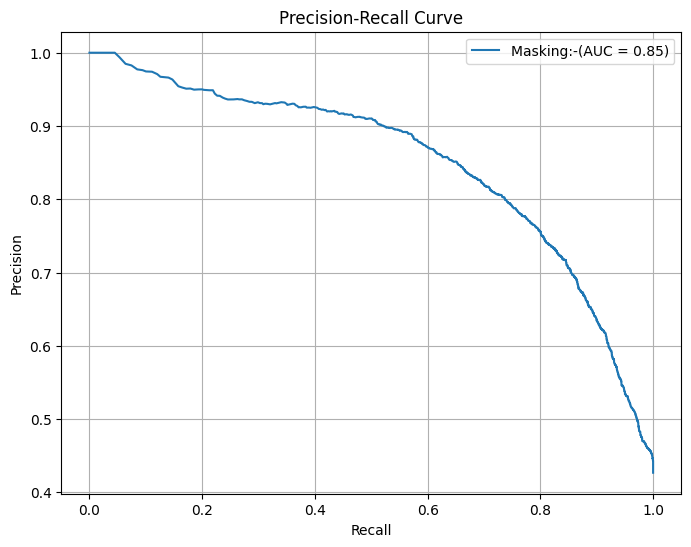

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Masking:-(AUC = {area:.2f})")
#plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc="best")
plt.show()

# ROC curve

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [20]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

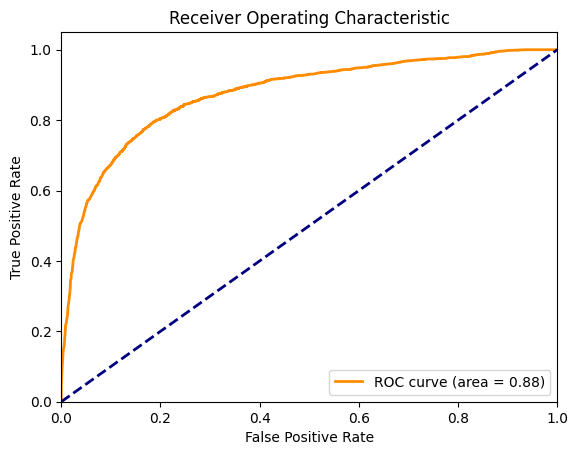

In [21]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [22]:
import csv


In [23]:
'''fp="/beegfs/.global0/ws/sapo684c-sac_space/ELAN_Mapping_prediction/prec_rec_v106_train.csv"
data = list(zip(y_true,y_scores))
with open(fp,mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['GT-106','PT-106'])
    writer.writerows(data)'''

'fp="/beegfs/.global0/ws/sapo684c-sac_space/ELAN_Mapping_prediction/prec_rec_v106_train.csv"\ndata = list(zip(y_true,y_scores))\nwith open(fp,mode=\'w\', newline=\'\') as file:\n    writer = csv.writer(file)\n    writer.writerow([\'GT-106\',\'PT-106\'])\n    writer.writerows(data)'

In [24]:
csv_filename=r"/beegfs/.global0/ws/sapo684c-sac_space/ELAN_Mapping_prediction/prec_rec_1300_train_msec.csv"
data=[]
with open(csv_filename, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    header = next(csv_reader)
    for row in csv_reader:
        data.append(row)
print(data)
new_header = header + ["GT-v106", "PT-v106"]
combined_data = []
for existing_row, val1, val2 in zip(data, y_true, y_scores):
    combined_data.append(existing_row + [val1, val2])



with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(new_header)
    csv_writer.writerows(combined_data)

print(f"CSV file '{csv_filename}' updated successfully.")
    


NameError: name 'csv' is not defined

In [23]:
 # Replace with your actual y_scores data

csv_filename=r"/beegfs/.global0/ws/sapo684c-sac_space/ELAN_Mapping_prediction/prec_rec_250_without_NA_layer_msec.csv"

# Create a list of lists with custom headers
new_data = [["GT-v230", "PT-v230"]]  # Headers for y_true and y_scores
new_data += [[yt, ys] for yt, ys in zip(y_true, y_scores)]

# Write data with custom headers to a new CSV file
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(new_data)

print(f"CSV file '{csv_filename}' created successfully.")

CSV file '/beegfs/.global0/ws/sapo684c-sac_space/ELAN_Mapping_prediction/prec_rec_250_without_NA_layer_msec.csv' created successfully.


# Precision-Recall curve All together

In [24]:
len(y_scores)

1656

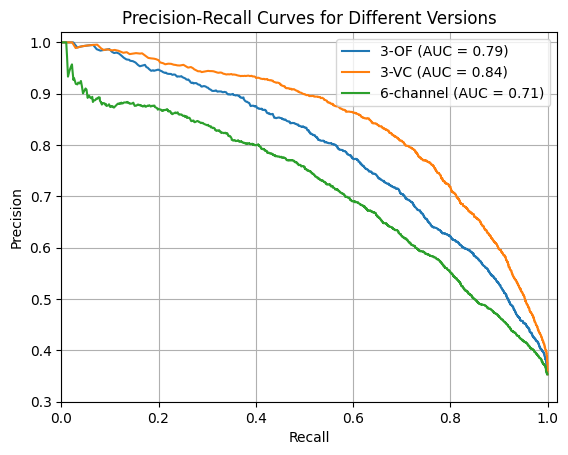

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Load the CSV file using pandas
csv_filename = "/beegfs/.global0/ws/sapo684c-sac_space/ELAN_Mapping_prediction/prec_rec_250_msec.csv"  # Update with your file name
df = pd.read_csv(csv_filename)

# List of versions
version_labels = {'v228': '3-OF', 'v225': '3-VC', 'v237': '6-channel'}
#version_labels = {'v104': '3-OF', 'v98': '3-VC', 'v106': '6-channel'}
versions= [106,104,98]

# Iterate through each version
for version in version_labels.keys():
    gt_column = f"GT-{version}"
    pt_column = f"PT-{version}"

    gt_values = df[gt_column]
    pt_values = df[pt_column]

    precision, recall, _ = precision_recall_curve(gt_values, pt_values)
    area = auc(recall, precision)

    plt.plot(recall, precision, label=f"{version_labels[version]} (AUC = {area:.2f})")

# Customize the plot
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Different Versions")
plt.legend(loc="best")
plt.grid(True)

plt.xlim(0, 1.02)  # Set x-axis limits
plt.ylim(0.3, 1.02)

plt.show()


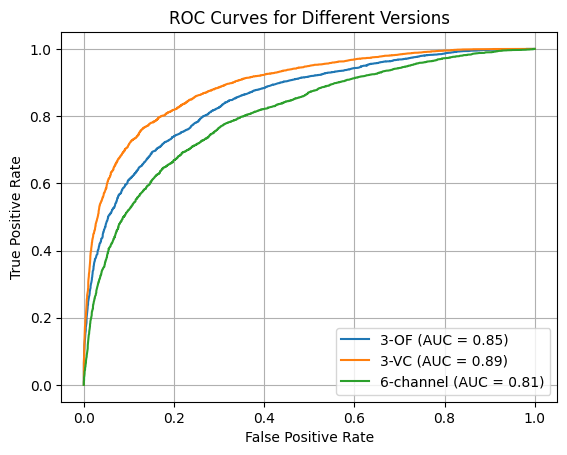

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load the CSV file using pandas
csv_filename = "/beegfs/.global0/ws/sapo684c-sac_space/ELAN_Mapping_prediction/prec_rec_250_msec.csv"  # Update with your file name
df = pd.read_csv(csv_filename)

# Define version-label mappings
version_labels = {'v228': '3-OF', 'v225': '3-VC', 'v237': '6-channel'}

# Iterate through each version
for version in version_labels.keys():
    gt_column = f"GT-{version}"
    pt_column = f"PT-{version}"

    gt_values = df[gt_column]
    pt_values = df[pt_column]

    fpr, tpr, _ = roc_curve(gt_values, pt_values)
    area = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{version_labels[version]} (AUC = {area:.2f})")

# Customize the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Versions")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# Probab Distribution

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(len(flattened_prediction_list))

In [ ]:
neg_list=[]
pos_list=[]

In [ ]:
for elem in flattened_prediction_list:
    if elem >= 0.5:
        pos_list.append(elem)
    else:
        neg_list.append(elem)

In [ ]:
print(len(pos_list))

In [ ]:
print(len(neg_list))

In [ ]:
plt.hist(neg_list, bins=10, histtype= 'bar')
plt.hist(pos_list, bins=10)

In [ ]:
plt.hist(flattened_prediction_list, bins=10)

In [ ]:
plt.hist(flattened_ground_list, bins=10)

In [ ]:
flattened_ground_list

In [ ]:
flattened_prediction_list

# Correct Prob Distribution

In [22]:
import matplotlib.pyplot as plt

In [23]:
for val1, val2,val3 in zip(flattened_ground_list,flattened_prediction_list,flattened_list):
    print(val1,val2,val3)

0.0 0.11536 000000000_2014-12-04_775-1563.npz
0.0 0.1995 000000001_2014-12-04_775-1563.npz
0.0 0.285 000000002_2014-12-04_775-1563.npz
0.0 0.05954 000000003_2014-12-04_775-1563.npz
0.0 0.03928 000000004_2014-12-04_775-1563.npz
0.0 0.02391 000000005_2014-12-04_775-1563.npz
0.0 0.0278 000000006_2014-12-04_775-1563.npz
0.0 0.013535 000000007_2014-12-04_775-1563.npz
0.0 0.02203 000000008_2014-12-04_775-1563.npz
0.0 0.1103 000000009_2014-12-04_775-1563.npz
0.0 0.1249 000000010_2014-12-04_775-1563.npz
0.0 0.1956 000000011_2014-12-04_775-1563.npz
0.0 0.01865 000000012_2014-12-04_775-1563.npz
0.0 0.546 000000013_2014-12-04_775-1563.npz
0.0 0.598 000000014_2014-12-04_775-1563.npz
0.0 0.1967 000000015_2014-12-04_775-1563.npz
0.0 0.2922 000000016_2014-12-04_775-1563.npz
0.0 0.209 000000017_2014-12-04_775-1563.npz
0.0 0.3044 000000018_2014-12-04_775-1563.npz
0.0 0.1715 000000019_2014-12-04_775-1563.npz
0.0 0.1813 000000020_2014-12-04_775-1563.npz
0.0 0.259 000000021_2014-12-04_775-1563.npz
0.0 0.1

In [24]:
neg=[]
pos=[]
for elem1, elem2 in zip(flattened_ground_list,flattened_prediction_list):
    if elem1==0.0:
        neg.append(elem2)
    else:
        pos.append(elem2)
      
        

In [25]:
print(len(neg))

5570


In [26]:
print(len(pos))

3045


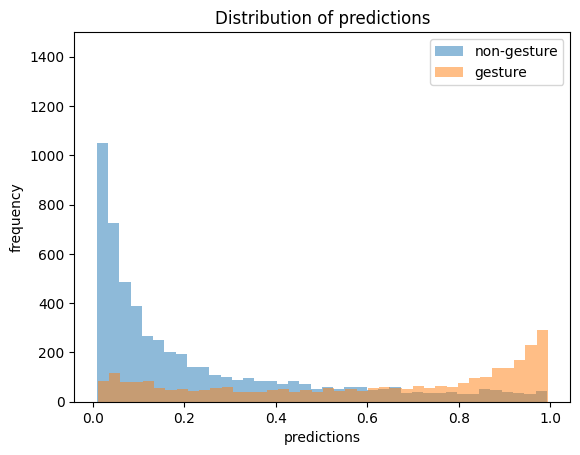

In [27]:
plt.hist(neg, bins=40, histtype= 'bar', alpha =0.5, label='non-gesture')
plt.hist(pos, bins=40, histtype= 'bar',alpha =0.5,label='gesture')
plt.xlabel("predictions")
plt.title('Distribution of predictions')
plt.ylabel("frequency")
plt.legend()
plt.ylim(0,1500)
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_256756/3665489821.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data1, shade=True, label="Non gesture",bw_adjust=0.4)
/tmp/ipykernel_256756/3665489821.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=True, label="gesture",bw_adjust=0.4)


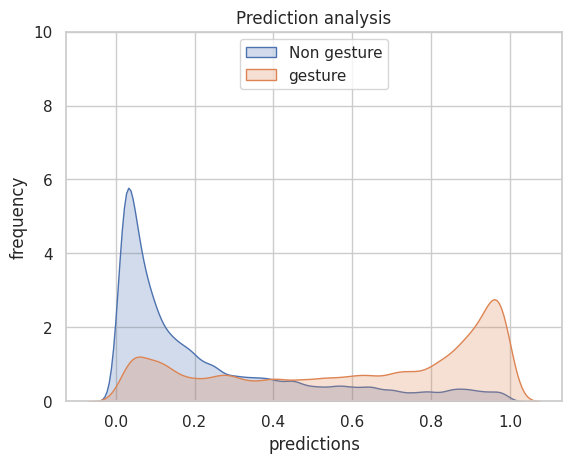

In [29]:
data1=neg
data2=pos
sns.set(style="whitegrid")
sns.kdeplot(data1, shade=True, label="Non gesture",bw_adjust=0.4)
sns.kdeplot(data2, shade=True, label="gesture",bw_adjust=0.4)
plt.xlabel("predictions")
plt.ylabel("frequency")
plt.title("Prediction analysis")
plt.legend(loc='upper center')
plt.ylim(0,10)
plt.show()


# Analysis of FN, FP

Writing all prediction for all snippets

In [ ]:
full=[]
for val1, val2,val3 in zip(flattened_ground_list,flattened_prediction_list,flattened_list):
    dist={'GT':np.float(val1),'PT':np.float(val2),'File':val3}
    full.append(dist)     
        
newfp=r'/beegfs/.global0/ws/sapo684c-sac_space/Testing_from_models/False_positive_negative_analysis/version98.json'

import json
with open(newfp,'w') as file:
    json.dump(full,file)

Writing prediction for FP, FN

In [ ]:
FN=[]
FP=[]
for val1, val2,val3 in zip(flattened_ground_list,flattened_prediction_list,flattened_list):
    if val1==0 and val2>=0.5:
        dist={'GT':np.float(val1),'PT':np.float(val2),'File':val3}
        FP.append(dist)
    if val1==1 and val2<0.5:
        dist={'GT':np.float(val1),'PT':np.float(val2),'File':val3}
        FN.append(dist)

In [ ]:
wrong=FP+FN

In [ ]:
newfp=r'/beegfs/.global0/ws/sapo684c-sac_space/Testing_from_models/False_positive_negative_analysis/version98_FP_FN.json'

In [ ]:
import json
with open(newfp,'w') as file:
    json.dump(wrong,file)

In [ ]:

with open(newfp, 'r') as file:
    loaded_data = json.load(file)

print(loaded_data)